## Data Setup

In [6]:
import numpy as np
from Py6S import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb_double')

In [7]:
def sph_to_eucl(theta, phi):
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

In [3]:
solar_zenith = 45
solar_azimuth = 0

wind_speed = 25
wind_direction = 0

wavelength = 0.55

pigmentation = 0.3
chlorinity = 19
salinity = 34.3

## 6S Validation

In [40]:
sixs_azimuths_o = np.arange(0, 361, 10)
sixs_zeniths_o = np.arange(0, 90, 10)

In [41]:
# For a given specification, compute the sixs BRDF
def compute_sixs_brdf():
    foam_result = np.zeros((len(sixs_azimuths_o), len(sixs_zeniths_o)))
    glint_result = np.zeros((len(sixs_azimuths_o), len(sixs_zeniths_o)))
    water_result = np.zeros((len(sixs_azimuths_o), len(sixs_zeniths_o)))
    total_result = np.zeros((len(sixs_azimuths_o), len(sixs_zeniths_o)))

    progress = tqdm(total=len(sixs_azimuths_o) * len(sixs_zeniths_o))

    azimuth_idx = 0
    for azimuth_out in sixs_azimuths_o:
        zenith_idx = 0
        for zenith_out in sixs_zeniths_o:
            s = SixS()
            s.wavelength = Wavelength(wavelength)
            s.atmos_profile = AtmosProfile.PredefinedType(AtmosProfile.NoGaseousAbsorption)
            s.aero_profile = AeroProfile.PredefinedType(AeroProfile.NoAerosols)
            s.ground_reflectance = GroundReflectance.HomogeneousOcean(wind_speed, wind_direction, salinity, pigmentation)

            # Set view parameters
            s.geometry = Geometry.User()
            s.geometry.solar_a = solar_azimuth
            s.geometry.solar_z = solar_zenith
            s.geometry.view_a = azimuth_out
            s.geometry.view_z = zenith_out

            # Run the simulation
            s.run()
            foam = s.outputs.values['water_component_foam']
            glint = s.outputs.values['water_component_glint']
            water = s.outputs.values['water_component_water']
            total = foam + glint + water

            # Save the results
            foam_result[azimuth_idx, zenith_idx] = foam
            glint_result[azimuth_idx, zenith_idx] = glint
            water_result[azimuth_idx, zenith_idx] = water
            total_result[azimuth_idx, zenith_idx] = total * np.cos(np.deg2rad(zenith_out))

            # Update the progress bar
            progress.update(1)

            zenith_idx += 1
        azimuth_idx += 1

    return foam_result.T, glint_result.T, water_result.T, total_result.T


In [42]:
foam, glint, water, total = compute_sixs_brdf()

100%|██████████| 333/333 [01:11<00:00,  4.64it/s]


In [43]:
# Statistics
print(f'Foam Statistics')
print(f'    Foam min: {np.min(foam)}')
print(f'    Foam max: {np.max(foam)}')
print(f'    Foam mean: {np.mean(foam)}')

print(f'Glint Statistics')
print(f'    Glint min: {np.min(glint)}')
print(f'    Glint max: {np.max(glint)}')
print(f'    Glint mean: {np.mean(glint)}')

print(f'Water Statistics')
print(f'    Water min: {np.min(water)}')
print(f'    Water max: {np.max(water)}')
print(f'    Water mean: {np.mean(water)}')

Foam Statistics
    Foam min: 0.05407
    Foam max: 0.05407
    Foam mean: 0.05407000000000001
Glint Statistics
    Glint min: 0.0
    Glint max: 0.78606
    Glint mean: 0.024298678678678676
Water Statistics
    Water min: 0.00652
    Water max: 0.00705
    Water mean: 0.006795555555555555


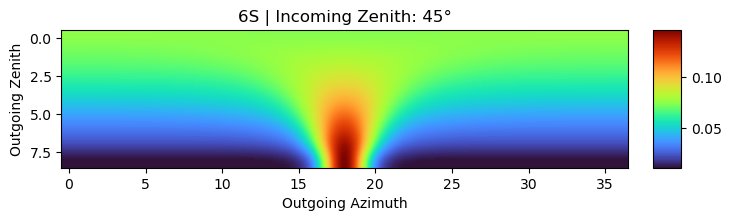

In [44]:
# Plot values for spherical coordinates
fig, ax = plt.subplots(figsize=(8, 4))
visual_set = [foam, glint, water, total]
channel = 3
im = ax.imshow(visual_set[channel], interpolation='spline36', cmap='turbo')
#im = ax.imshow(visual_set[channel], interpolation='None', cmap='turbo')

# Name the axes
plt.xlabel("Outgoing Azimuth")
plt.ylabel("Outgoing Zenith")

# Add the title
degrees = np.degrees(solar_zenith)

# Round to 2 decimal places
degrees = round(degrees, 2)

# Add Title
ax.set_title(f'6S | Incoming Zenith: {solar_zenith}°')

# Add color bar with same height as the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)
plt.show()

## Mitsuba Implementation

In [8]:
# Create a dummy surface interaction to use for the evaluation of the BSDF
si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with X degrees
si.wi = sph_to_eucl(dr.deg2rad(solar_zenith), dr.deg2rad(solar_azimuth))

# Set the surface normal to point upwards
si.n = mi.Vector3f(0, 0, 1)

# Create grid in spherical coordinates and map it into a sphere
res = 50
zeniths_o, azimuths_o = dr.meshgrid(
    dr.linspace(mi.Float, np.deg2rad(1), np.deg2rad(89), res),
    dr.linspace(mi.Float, 0, 2 * dr.pi, 2 * res)
)

print(f'Evaluations: {len(zeniths_o) * len(azimuths_o)}')

wo = sph_to_eucl(zeniths_o, azimuths_o)

Evaluations: 25000000


In [10]:
bsdf = mi.load_dict({
        'type': 'oceanic_legacy',
        'channel': 3,
        'visual_type': 0,
        'wavelength': wavelength,
        'wind_speed': wind_speed,
        'wind_direction': wind_direction,
        'chlorinity': chlorinity,
        'pigmentation': pigmentation,
        'shininess': 50,
    })
brdf = bsdf.eval(mi.BSDFContext(), si, wo)
brdf = np.array(brdf)
brdf = brdf[:,0]
brdf = brdf.reshape(2 * res, res).T

2024-08-07 14:55:46 WARN main [oceanic_legacy.cpp:447] Upwell: [0.978595, 0.978585, 0.97857, 0.978552, 0.97853, .. 4990 skipped .., 0.968119, 0.967986, 0.967884, 0.967816, 0.96778], Downwell: [0.969505]

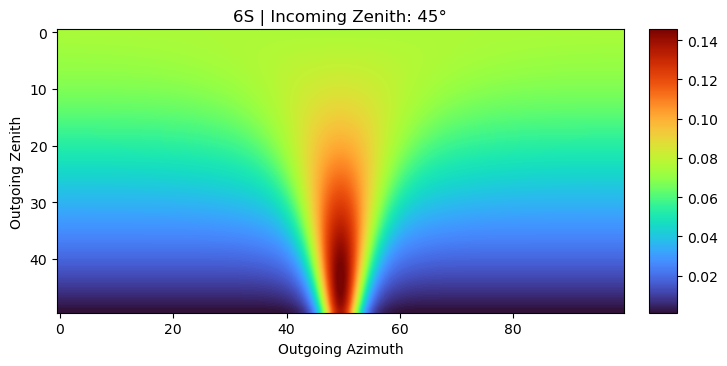

In [11]:
# Plot values for spherical coordinates
fig, ax = plt.subplots(figsize=(8, 4))
channel = 3
im = ax.imshow(brdf, interpolation='spline36', cmap='turbo')
#im = ax.imshow(visual_set[channel], interpolation='None', cmap='turbo')

# Name the axes
plt.xlabel("Outgoing Azimuth")
plt.ylabel("Outgoing Zenith")

# Add the title
degrees = np.degrees(solar_zenith)

# Round to 2 decimal places
degrees = round(degrees, 2)

# Add Title
ax.set_title(f'6S | Incoming Zenith: {solar_zenith}°')

# Add color bar with same height as the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)
plt.show()

In [ ]:
'''
# To compare the BRDFs, we rescale both 6S and Mitsuba BRDFs to the same range
# of [0, 2pi] for the azimuth and [0, pi / 2] for the zenith
sixs_azimuths = np.deg2rad(sixs_azimuths_o)
sixs_zeniths = np.deg2rad(sixs_zeniths_o)

# Rescale the 6S BRDF
sixs_azimuths = np.linspace(0, 2 * np.pi, len(sixs_azimuths_o))
sixs_zeniths = np.linspace(0, np.pi / 2, len(sixs_zeniths_o))

# Rescale the Mitsuba BRDF
azimuths = np.linspace(0, 2 * np.pi, 2 * res)
zeniths = np.linspace(0, np.pi / 2, res)

# Plot values for spherical coordinates
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(visual_set[channel], interpolation='spline36', cmap='turbo')
'''